# FRAUD DETECTION ON BANKSIM DATASET

In [7]:
#Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
#sns.set()
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight") 
# Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix, classification_report

# Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier


In [8]:
df = pd.read_csv("Banksim_dataset.csv")
df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


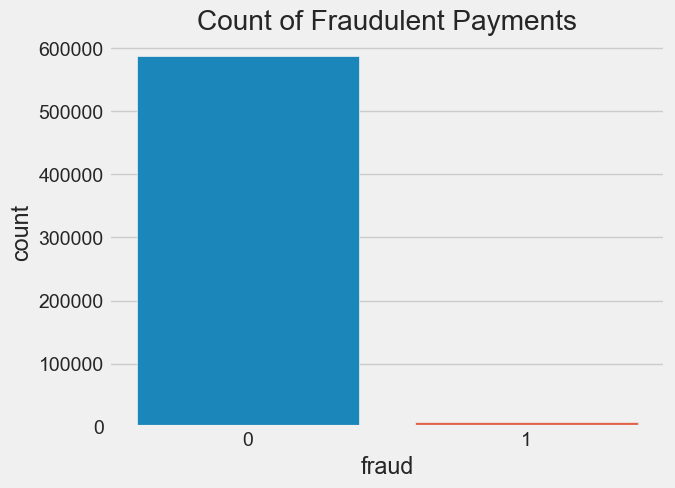

Number of normal examples:  587443
Number of fradulent examples:  7200
0    587443
1      7200
Name: fraud, dtype: int64


In [10]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

sns.countplot(x="fraud",data=df)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
print(df.fraud.value_counts()) # does the same thing above

### We can see the mean amount and fraud percent by category below. Looks like leisure and the travel is the most selected categories for fraudsters. Fraudsters chose the categories which people spend more on average. Let's confirm this hypothesis by checking the fraud and non-fraud amount transacted.

In [11]:
print("Mean feature values per category")
print(df.groupby('category')[['amount','fraud']].mean())

Mean feature values per category
                              amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


### Our hypothesis for fraudsters choosing the categories which people spend more is only partly correct, but as we can see in the table below we can say confidently say that a fraudulent transaction will be much more (about four times or more) than average for that category.

In [12]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           df.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


### Average amount spend it categories are similar; between 0-500 discarding the outliers, except for the travel category which goes very high.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


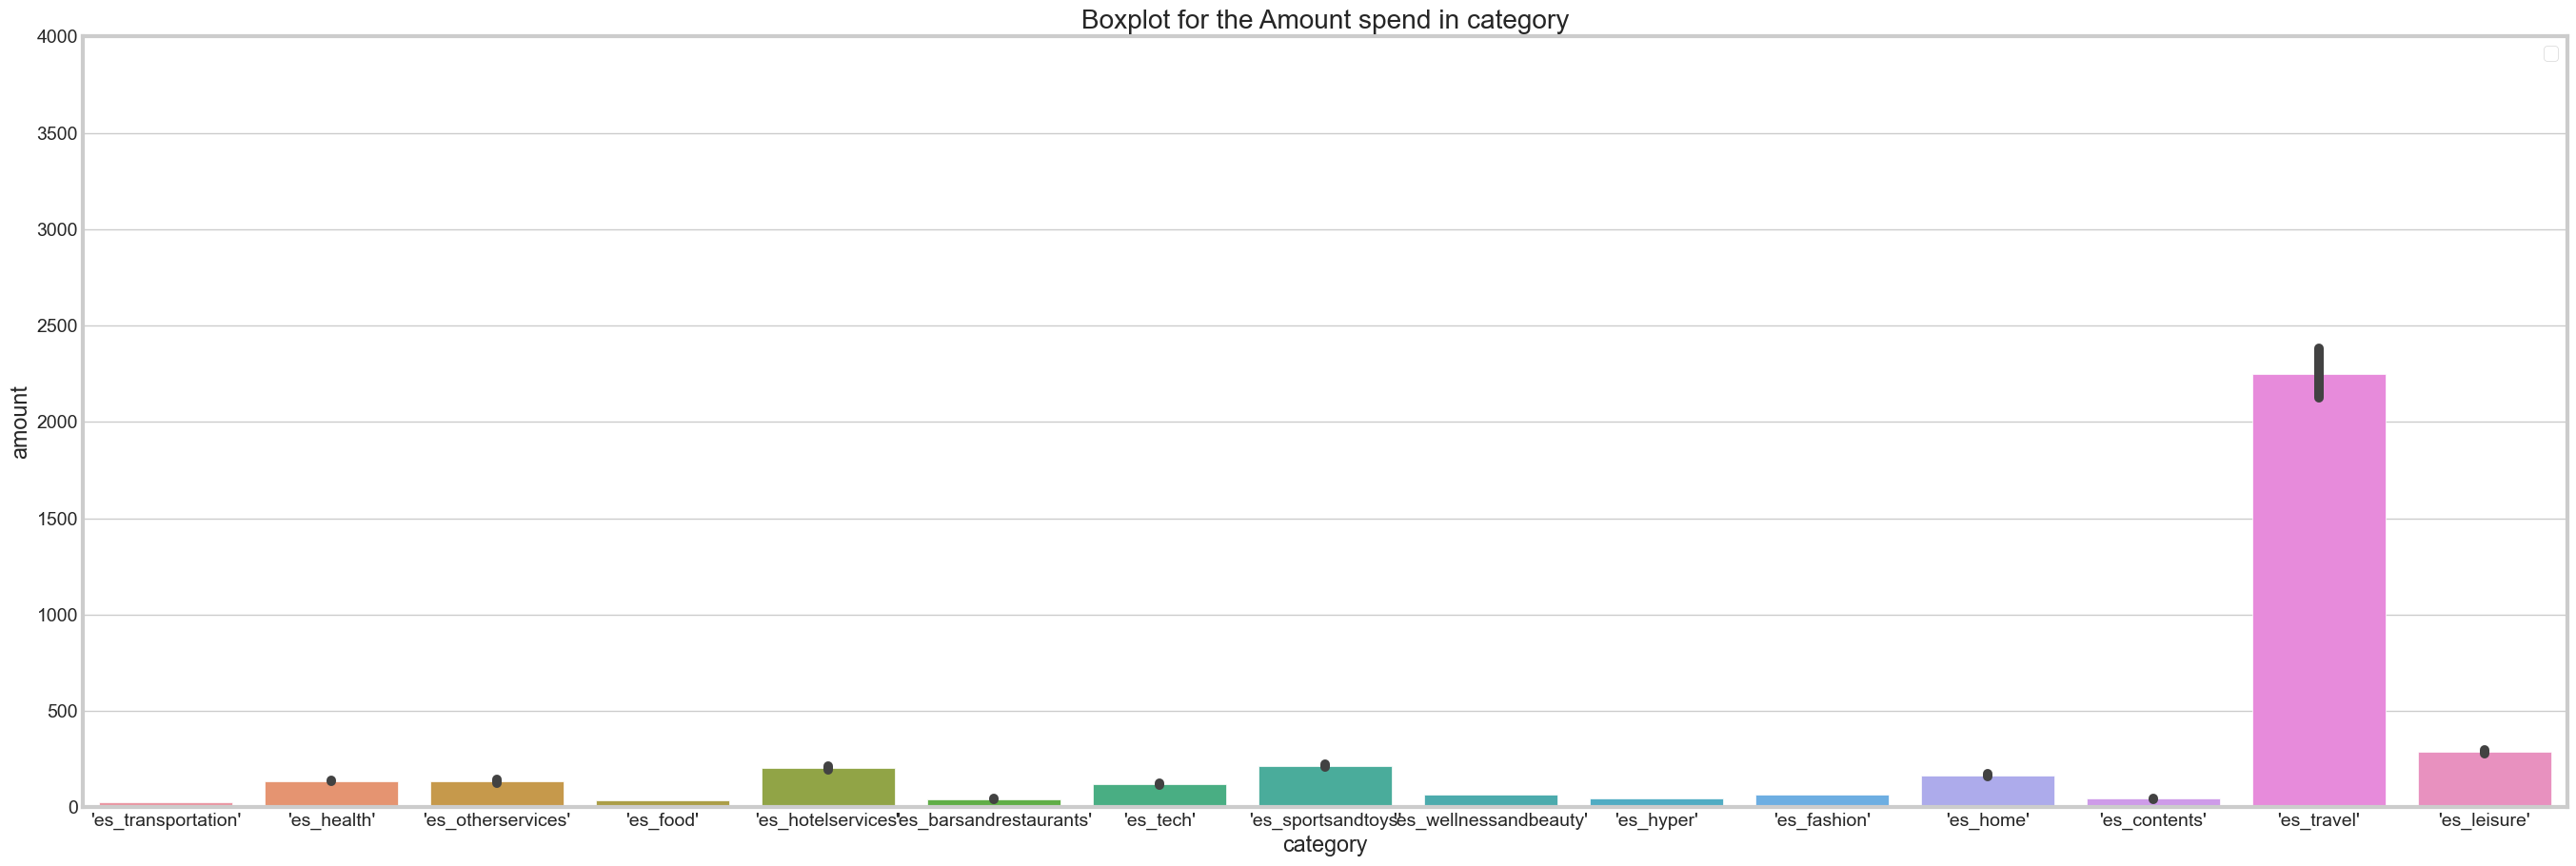

In [13]:
sns.set_style("whitegrid")
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.barplot(x=df.category,y=df.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

### Again we can see in the histogram below the fradulent transactions are less in count but more in amount

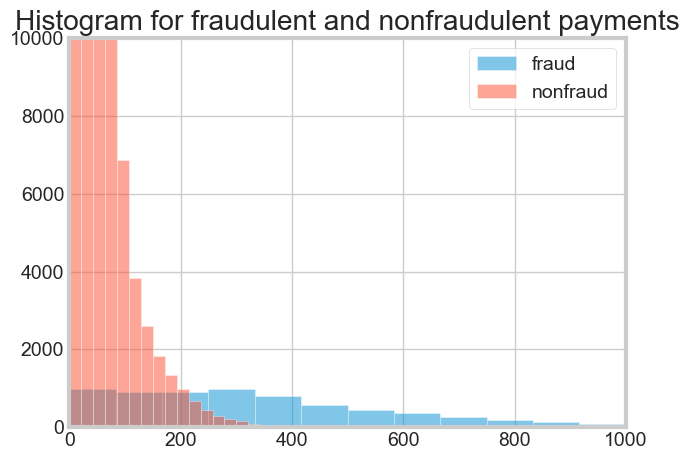

In [14]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

C:\Users\viswanath\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

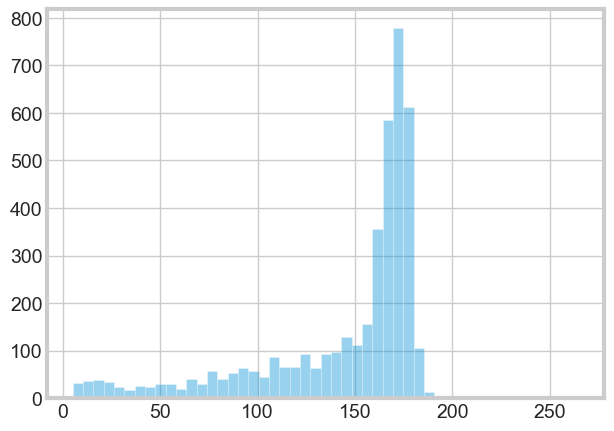

In [15]:
cust = df.groupby('customer').apply(lambda df:len(df))
sns.distplot(cust.values,kde=False)

### Looks like fraud occurs more in ages equal and below 18(0th category). Can it be because of fraudsters thinking it would be less consequences if they show their age younger, or maybe they really are young.

In [16]:
print((df.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


# Data Preprocessing

In this part we will preprocess the data and prepare for the training.

There are only one unique zipCode values so we will drop them.

In [17]:
print("Unique zipCodeOri values: ",df.zipcodeOri.nunique())
print("Unique zipMerchant values: ",df.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = df.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


Checking the data after dropping.

In [18]:
data_reduced.columns


Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

Here we will transform categorical features into numerical values. It is usually better to turn these type of categorical values into dummies because they have no relation in size(i.e. customer1 is not greater than customer2) but since they are too many (over 500k customers and merchants) the features will grow 10^5 in size and it will take forever to train. I've put the code below for turning categorical features into dummies if you want to give it a try.
> data_reduced.loc[:,['customer','merchant','category']].astype('category')
> data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) # dummies
> print(data_dum.info())

In [19]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


Let's define our independent variable (X) and dependant/target variable y

In [20]:
X = data_reduced.drop(['fraud'],axis=1)
y = df['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [21]:
y[y==1].count()

7200

# Oversampling with SMOTE

Using SMOTE(Synthetic Minority Oversampling Technique) [2] for balancing the dataset. Resulted counts show that now we have exact number of class instances (1 and 0).

In [22]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res.value_counts())

fraud
0        587443
1        587443
dtype: int64


I will do a train test split for measuring the performance. I haven't done cross validation since we have a lot of instances and i don't want to wait that much for training but it should be better to cross validate most of the times.

In [23]:
# I won't do cross validation since we have a lot of instances
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

As i talked about it before fraud datasets will be imbalanced and most of the instances will be non-fraudulent. Imagine that we have the dataset here and we are always predicting non-fraudulent. Our accuracy would be almost 99 % for this dataset and mostly for others as well since fraud percentage is very low. Our accuracy is very high but we are not detecting any frauds so it is a useless classifier. So the base accuracy score should be better at least than predicting always non-fraudulent for performing a detection.

In [24]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


# Logistic Regression

In [25]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initializing the Logistic Regression model
model = LogisticRegression()

# Training the model
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_test_scaled)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))


C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
 0.9214449053242015
Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92    176233
           1       0.95      0.89      0.92    176233

    accuracy                           0.92    352466
   macro avg       0.92      0.92      0.92    352466
weighted avg       0.92      0.92      0.92    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[167230   9003]
 [ 18685 157548]]


# K-Neighbours Classifier

In [26]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))




C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy:
 0.9869604444116595
Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


# Random Forest Classifier

In [27]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))


C:\Users\viswanath\AppData\Local\Temp\ipykernel_19476\2812642586.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s


Accuracy:
 0.9795554748543122
Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


# Xgboost

In [28]:
XGBoost_CLF= xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbose=True)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))


C:\Users\viswanath\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [21:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy:
 0.9917155129856496
Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174100   2133]
 [   787 175446]]


# Decision Tree

In [29]:

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Decision Tree: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Decision Tree: \n", confusion_matrix(y_test,y_pred))




Accuracy:
 0.9935681739515301
Classification Report for Decision Tree: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of Decision Tree: 
 [[174704   1529]
 [   738 175495]]


# Naive Bayes

In [30]:
# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)
# Evaluate accuracy
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Navive Bayes: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Navive Bayes: \n", confusion_matrix(y_test,y_pred))





C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
 0.9138725437347148
Classification Report for Navive Bayes: 
               precision    recall  f1-score   support

           0       0.90      0.93      0.91    176233
           1       0.92      0.90      0.91    176233

    accuracy                           0.91    352466
   macro avg       0.91      0.91      0.91    352466
weighted avg       0.91      0.91      0.91    352466

Confusion Matrix of Navive Bayes: 
 [[163263  12970]
 [ 17387 158846]]


# Gradient Boosting Machines (GBM)

In [31]:
gbm_classifier = GradientBoostingClassifier()

# Train the classifier
gbm_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = gbm_classifier.predict(X_test)
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Navive Bayes: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Navive Bayes: \n", confusion_matrix(y_test,y_pred))
print("Roc Auc Score:", roc_auc_score(y_test, y_pred))


C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
 0.978588005651609
Classification Report for Navive Bayes: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Navive Bayes: 
 [[171073   5160]
 [  2387 173846]]
Roc Auc Score: 0.978588005651609


# Isolation Forest

In [32]:
# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)  # Contamination parameter depends on the expected proportion of anomalies
model.fit(X_train)

# Predict the anomaly scores on the test set
anomaly_scores = model.decision_function(X_test)

# Convert anomaly scores to binary predictions (0 for normal, 1 for anomaly)
y_pred = [1 if score < 0 else 0 for score in anomaly_scores]

print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Navive Bayes: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Navive Bayes: \n", confusion_matrix(y_test,y_pred))


C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Accuracy:
 0.5341536488625853
Classification Report for Navive Bayes: 
               precision    recall  f1-score   support

           0       0.52      0.93      0.67    176233
           1       0.67      0.14      0.23    176233

    accuracy                           0.53    352466
   macro avg       0.59      0.53      0.45    352466
weighted avg       0.59      0.53      0.45    352466

Confusion Matrix of Navive Bayes: 
 [[164325  11908]
 [152287  23946]]


# AdaBoost

In [33]:

# Initialize the AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()

# Train the classifier on the training data
adaboost_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = adaboost_classifier.predict(X_test)
print("Accuracy:\n" ,accuracy_score(y_test, y_pred))

print("Classification Report for Navive Bayes: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Navive Bayes: \n", confusion_matrix(y_test,y_pred))




C:\Users\viswanath\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
 0.9650831569569831
Classification Report for Navive Bayes: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97    176233
           1       0.97      0.96      0.96    176233

    accuracy                           0.97    352466
   macro avg       0.97      0.97      0.97    352466
weighted avg       0.97      0.97      0.97    352466

Confusion Matrix of Navive Bayes: 
 [[170534   5699]
 [  6608 169625]]
